In [26]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import Xception
from sklearn.preprocessing import LabelEncoder


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Crear un DataGenerator personalizado para el conjunto de datos

In [52]:
from sklearn.model_selection import train_test_split

class DataGenerator(Sequence):

    def __init__(self, df, batch_size = 32, dim=(64,64), n_channels=3,
                 n_classes=10, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        # Generate indexes of the batch
        batch_indices = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Find list of IDs
        df_batch = self.df.iloc[batch_indices,:]
        df_batch = df_batch.reset_index()
        # Generate data
        X, y = self.__data_generation(df_batch)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, df_batch):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i in range(len(df_batch)):
            img = image.load_img(df_batch.loc[i,'path'], target_size=self.dim)
            X[i] = image.img_to_array(img)
            y[i] = df_batch.loc[i,'label']

        return X, y

In [53]:
def gather_dataset_info(root_path):
    data = {'path': [], 'label': []}
    
    # Walk through each directory in the root_path
    for dirpath, dirnames, filenames in os.walk(root_path):
        # Assuming that directory names in root_path are class names
        for filename in filenames:
            # Ensure we're only picking up image files (you can add more extensions if needed)
            if filename.endswith(('.JPEG')):
                data['path'].append(os.path.join(dirpath, filename))
                parent_of_parent_dir = os.path.dirname(dirpath)
                label = os.path.basename(parent_of_parent_dir)
                data['label'].append(label)  # Class label is the name of the parent directory

    df = pd.DataFrame(data)
    return df

In [54]:
def map_labels_to_numbers(df, label_column):
    """
    Maps text labels in a DataFrame to numbers.

    Parameters:
    - df: The input DataFrame.
    - label_column: The column name containing the text labels.

    Returns:
    - df: DataFrame with labels mapped to numbers.
    - label_map: Dictionary mapping original labels to numbers.
    """
    # Create a mapping from label to number
    unique_labels = df[label_column].unique()
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    
    # Apply the mapping to the DataFrame
    df[label_column] = df[label_column].map(label_map)
    
    return df, label_map

In [55]:
# Create the data generator
batch_size = 32
image_size = (64, 64)
num_channels = 3

DIR_MAIN = '/kaggle/input/tiny-imagenet/tiny-imagenet-200/tiny-imagenet-200/'
DIR_TRAIN = DIR_MAIN + 'train/'
DIR_VAL = DIR_MAIN + 'val/'
DIR_TEST = DIR_MAIN + 'test/'

train_df = gather_dataset_info(DIR_TRAIN)
train_df, label_map = map_labels_to_numbers(train_df, 'label')

# test_df = gather_dataset_info(DIR_TEST)
# test_df, label_map = map_labels_to_numbers(test_df, 'label')

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

print("Training DataFrame:")
print(train_df['label'].value_counts())

print("\nValidation DataFrame:")
print(val_df['label'].value_counts())

# print("\nTesting DataFrame:")
# print(test_df['label'].value_counts())

train_data_gen = DataGenerator(df = train_df, batch_size = batch_size, dim = image_size, n_channels = num_channels)
val_data_gen = DataGenerator(val_df, batch_size, image_size, num_channels)
# test_data_gen = DataGenerator(test_df, batch_size, image_size, num_channels)



Training DataFrame:
label
74     400
113    400
11     400
86     400
114    400
      ... 
84     400
141    400
18     400
21     400
169    400
Name: count, Length: 200, dtype: int64

Validation DataFrame:
label
84     100
105    100
76     100
191    100
41     100
      ... 
44     100
60     100
45     100
43     100
15     100
Name: count, Length: 200, dtype: int64


# 2. Crear un modelo básico de red neuronal (utilizando dropout y batcnorm para regularizar)

In [56]:

# Define the CNN model with dropout and batch normalization
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model


In [57]:

input_shape = (64, 64, 3)  
num_classes = 200 

# Create the CNN model
model = create_cnn_model(input_shape, num_classes)

# Print model summary
model.summary()



Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 200)            │        25,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 710,408 (2.71 MB)

 Trainable params: 709,704 (2.71 MB)

 Non-trainable params: 704 (2.75 KB)

# 3. Entrenar el modelo y mostrar el rendimiento en los conjuntos de entrenamiento, validación y prueba

In [58]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


history = model.fit(train_data_gen, epochs=10, validation_data=val_data_gen)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-20 04:49:35.841594: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 6.39927, expected 5.58886
2024-03-20 04:49:35.841659: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.92185, expected 5.11143
2024-03-20 04:49:35.841670: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.99669, expected 5.18628
2024-03-20 04:49:35.841679: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.48891, expected 5.6785
2024-03-20 04:49:35.841688: E external/local_xla/xla/service/gpu/buffer_comparator.cc:113

   3/2500 ━━━━━━━━━━━━━━━━━━━━ 3:13 78ms/step - accuracy: 0.0035 - loss: 6.1967       

I0000 00:00:1710910182.162683     214 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710910182.187420     214 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2493/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.0377 - loss: 5.0836

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1710910577.828312     215 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 519s 201ms/step - accuracy: 0.0378 - loss: 5.0825 - val_accuracy: 0.1305 - val_loss: 4.1393
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 108s 43ms/step - accuracy: 0.1200 - loss: 4.1735 - val_accuracy: 0.1769 - val_loss: 3.8210
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 146s 45ms/step - accuracy: 0.1563 - loss: 3.9249 - val_accuracy: 0.1914 - val_loss: 3.7000
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 114s 45ms/step - accuracy: 0.1750 - loss: 3.7835 - val_accuracy: 0.2130 - val_loss: 3.5900
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 110s 44ms/step - accuracy: 0.1889 - loss: 3.6951 - val_accuracy: 0.2305 - val_loss: 3.4960
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 109s 43ms/step - accuracy: 0.2013 - loss: 3.6192 - val_accuracy: 0.2368 - val_loss: 3.4526
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 110s 44ms/step - accuracy: 0.2143 - loss: 3.5573 - val_accuracy: 0.2167 - val_loss: 3.5516
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 109s 43ms/step - accuracy: 0.2197 - l

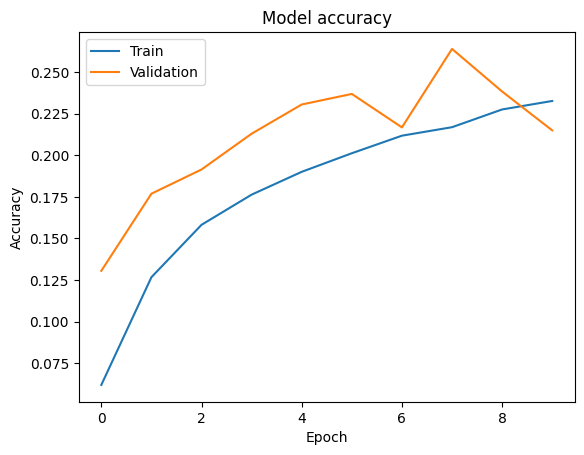

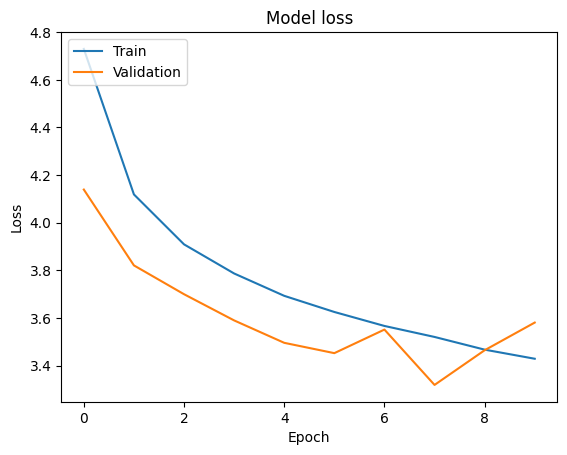

In [59]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 4. Descargar un modelo pre-entrenado, el que prefieran, y hacer transfer learning para mejorar la clasificación del modelo base.
##    Para esto pueden consultar en el siguiente link los modelos disponibles:
## https://keras.io/api/applications/

In [60]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(71,71,3))
base_model.trainable = False

In [61]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(200, activation='softmax'))
model.build((None,71,71,3))
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 3, 3, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 200)            │        51,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,437,424 (81.78 MB)

 Trainable params: 575,944 (2.20 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [62]:
# Create the data generator
batch_size = 32
image_size = (71, 71)
num_channels = 3

DIR_MAIN = '/kaggle/input/tiny-imagenet/tiny-imagenet-200/tiny-imagenet-200/'
DIR_TRAIN = DIR_MAIN + 'train/'
DIR_VAL = DIR_MAIN + 'val/'
DIR_TEST = DIR_MAIN + 'test/'

train_df = gather_dataset_info(DIR_TRAIN)
train_df, label_map = map_labels_to_numbers(train_df, 'label')

# test_df = gather_dataset_info(DIR_TEST)
# test_df, label_map = map_labels_to_numbers(test_df, 'label')

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

print("Training DataFrame:")
print(train_df['label'].value_counts())

print("\nValidation DataFrame:")
print(val_df['label'].value_counts())

# print("\nTesting DataFrame:")
# print(test_df['label'].value_counts())

train_data_gen = DataGenerator(df = train_df, batch_size = batch_size, dim = image_size, n_channels = num_channels)
val_data_gen = DataGenerator(val_df, batch_size, image_size, num_channels)
# test_data_gen = DataGenerator(test_df, batch_size, image_size, num_channels)


Training DataFrame:
label
74     400
113    400
11     400
86     400
114    400
      ... 
84     400
141    400
18     400
21     400
169    400
Name: count, Length: 200, dtype: int64

Validation DataFrame:
label
84     100
105    100
76     100
191    100
41     100
      ... 
44     100
60     100
45     100
43     100
15     100
Name: count, Length: 200, dtype: int64


In [64]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train_data_gen, epochs=10, validation_data=val_data_gen)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0048 - loss: 5.7154

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 138s 50ms/step - accuracy: 0.0048 - loss: 5.7153 - val_accuracy: 0.0050 - val_loss: 5.2982
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 124s 49ms/step - accuracy: 0.0043 - loss: 5.2994 - val_accuracy: 0.0050 - val_loss: 5.2983
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 120s 48ms/step - accuracy: 0.0047 - loss: 5.2993 - val_accuracy: 0.0050 - val_loss: 5.2982
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 117s 47ms/step - accuracy: 0.0044 - loss: 5.2996 - val_accuracy: 0.0050 - val_loss: 5.2980
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 117s 47ms/step - accuracy: 0.0047 - loss: 5.2987 - val_accuracy: 0.0050 - val_loss: 5.2983
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 121s 48ms/step - accuracy: 0.0050 - loss: 5.3077 - val_accuracy: 0.0050 - val_loss: 5.2981
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 123s 49ms/step - accuracy: 0.0043 - loss: 5.2981 - val_accuracy: 0.0050 - val_loss: 5.2983
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 120s 48ms/step - accuracy: 0.0045 - lo

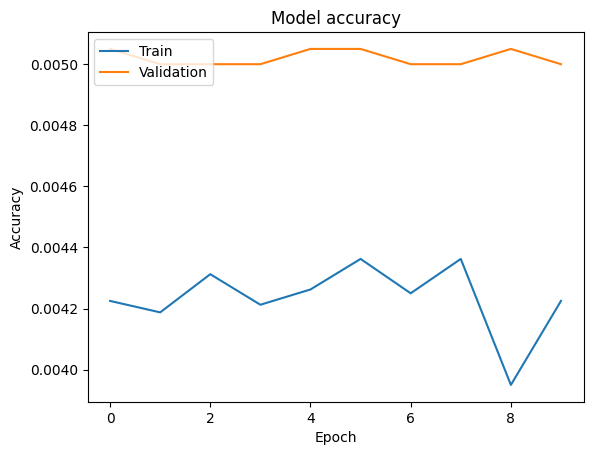

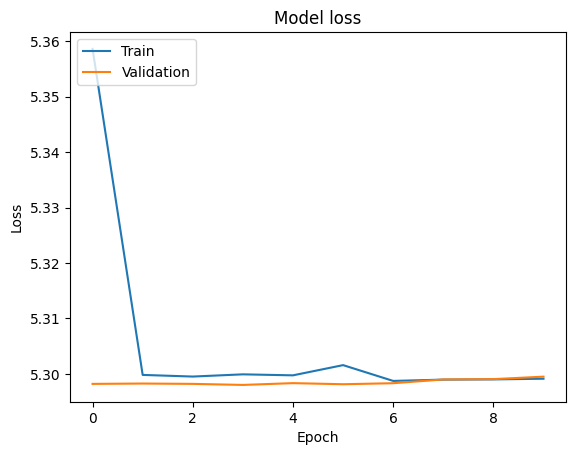

In [65]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()